In [ ]:
import numpy as np
import scipy.signal
from scipy.signal import butter, filtfilt, deconvolve
import scipy.io as sio
from scipy.stats.stats import zscore
from scipy import ndimage
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow
from matplotlib import gridspec
from matplotlib.patches import Ellipse
%matplotlib inline

import pyret.spiketools as spk
import pyret.stimulustools as st
import pyret.filtertools as ft
import pyret.visualizations as vis
import pyret.nonlinearities as nl
# ft.linear_response has a different dimension before version '0.6.0'
pyret.__version__
#pyret.visualizations.__all__

import h5py
import warnings

import pylab
from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
from os import listdir
from os.path import isfile, join

In [ ]:
plt.rcParams['animation.html'] = 'jshtml'
from IPython.display import HTML
import my

In [ ]:
# 0419 David intracellular h5 files:
data_dir = '/Users/peterfish/Modules/1d-whitenoise-analysis/raw-data-david/'
files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
files = [f for f in files if '.h5' in f]
files

In [ ]:
data = [dict() for i in range(len(files))]
# data[file id][cell id][flash or lines] = dic() ..
# data[file id][flash or lines] = dic() ..

i = 0 # file id
filename = data_dir + files[0]

In [ ]:
# load dataset by sequentially visiting all possible dataset groups.
all_obj = []
with h5py.File(filename, 'r') as f:
    print('Keys :', list(f.keys()))
    
    # visit all dataset
    f.visit(all_obj.append)
    all_datasets = [obj for obj in all_obj if isinstance(f[obj], h5py.Dataset)]   
    all_groups = [obj for obj in all_obj if isinstance(f[obj], h5py.Group)]
    print('Groups :', all_groups)
    
    for key in all_datasets:
        data[i][key] = np.array(f[key])    

In [ ]:
def visit_h5_keys(d):
    # d is a reference to h5 file.
    dataset = dict()
    
    for key in d.keys():
        if isinstance(d[key], h5py.Dataset):
            dataset[key] = np.array(d[key])
        elif isinstance(d[key], h5py.Group):
            dataset[key] = visit_keys(d[key])
        #else:
            # do somthing            
    return dataset

with h5py.File(filename, 'r') as f:
    d = visit_h5_keys(f)

In [ ]:
print(list(d['boxes'].keys()))

In [ ]:
rf = d['boxes']['rfs']
#rf = d['lines']['rfs']

In [33]:
t = d['boxes']['time']
t = t[0:38]
time = - t[::-1]

011914_cell_1


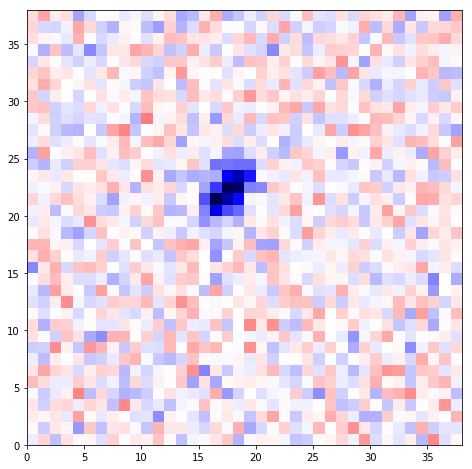

<Figure size 720x576 with 0 Axes>

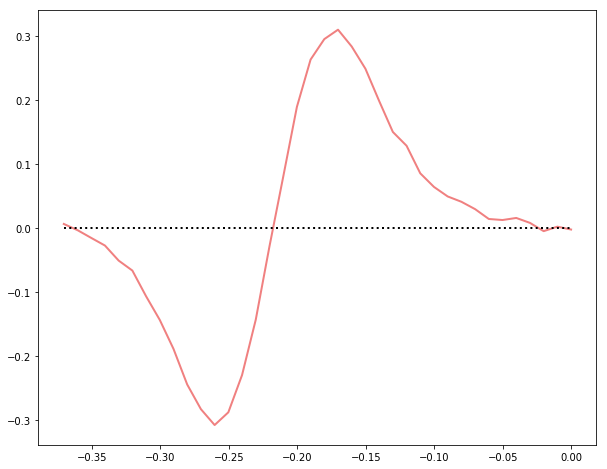

011914_cell_2


<Figure size 720x576 with 0 Axes>

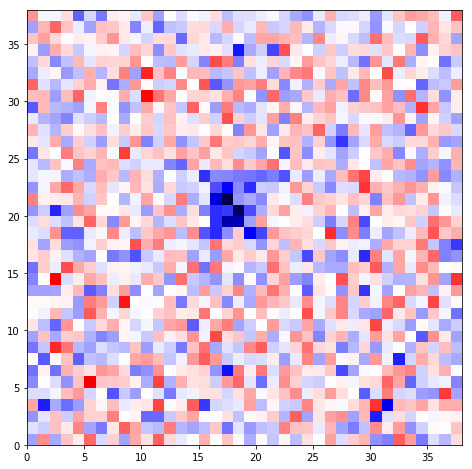

<Figure size 720x576 with 0 Axes>

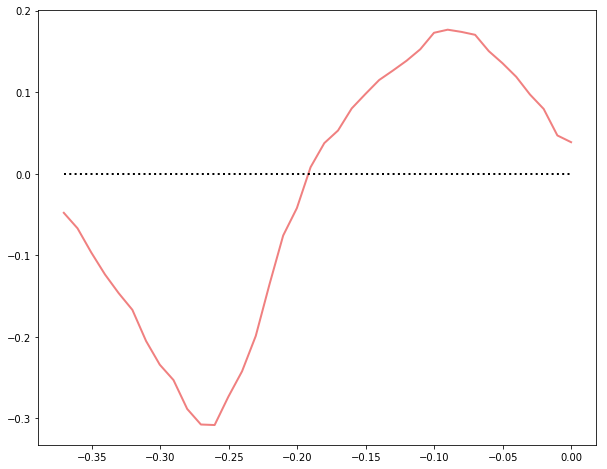

<Figure size 720x576 with 0 Axes>

In [35]:
i = 0;
for cell in rf.keys():
    if i<2:
        print(cell)
        r = rf[cell] # 38 x 38 x 38
        #plt.plot(r)
        vis.spatial(r)
        vis.temporal(time, r)
    i = i+1


In [24]:
vis.temporal?

Signature: vis.temporal(time, filt, **kwargs)
Docstring:
Plot the temporal component of a full linear filter.

If the given linear filter is 1D, it is assumed to be a temporal filter,
and is plotted directly. If the filter is 2 or 3D, it is decomposed into
its spatial and temporal components, and the temporal component is plotted.

Parameters
----------
time : array_like
    A time vector to plot against.

filt : array_like
    The full filter to plot. May be than 1D, but must match in size along
    the first dimension with the ``time`` input.

ax : matplotlib Axes object, optional
    the axes on which to plot the data; defaults to creating a new figure

Returns
-------
fig : matplotlib.figure.Figure
    The figure onto which the temoral STA is plotted.

ax : matplotlib Axes object
    Axes into which the temporal STA is plotted
File:      /usr/local/lib/python3.7/site-packages/pyret-0.6.0-py3.7.egg/pyret/visualizations.py
Type:      function


In [ ]:
vis.play_sta?

In [ ]:
resp = d['boxes']['membrane_potential']

cell = 0;

a = resp[cell]
plt.plot(a)
plt.plot(rf[cell])


In [ ]:
#
with h5py.File(filename, 'r') as f:
    print('Keys :', list(f.keys())) # contents of the dataset
                          # 'boxes', 'expts', 'flashes', 'lines' 
    for key in f.keys():
  
        print(key)
    
        dset = f[key]
        
        if key == 'expts': # cell names # sam
            data[i][key] = np.array(dset)
            
        else:
            data[i][key] = dict()
            
            print(list(dset.keys()))
            #
            for kk in dset.keys():
                
                data[i][key][kk] = np.array(dset[kk])
    #
    #dset = f['exp1']
    #print(list(dset.keys()))
    #print(list(dset.attrs.keys()))


In [ ]:
data[0]['lines'].keys()

In [ ]:
len(data[0]['lines']['rfs'])

In [ ]:
len(data[0]['expts'])

In [ ]:
f = h5py.File(filename, 'r')

In [ ]:
f['lines'].keys()

In [ ]:
f['expts']

In [ ]:

is_dataset = isinstance(item, h5py.Dataset)

In [ ]:
def h5py_dataset_iterator(g, prefix=''):
    for key in g.keys():
        item = g[key]
        path = '{}/{}'.format(prefix, key)
        if isinstance(item, h5py.Dataset): # test for dataset
            yield (path, item)
        elif isinstance(item, h5py.Group): # test for group (go down)
            yield from h5py_dataset_iterator(item, path)

with h5py.File('test.hdf5', 'r') as f:
    for (path, dset) in h5py_dataset_iterator(f):
        print(path, dset)



In [ ]:
#date = '17-11-08'
#retina_num = 1
#cell_num = 5

### Rarely change
fine_name_i_rf_line = date + '-r' + str(retina_num) + '-c' + str(cell_num) + '-1-line.h5'


frame_num_rf_30m = 54000
kernel_length_rf = 0.5 # in [s]
upsample_factor_g_rf = 4

#
frame_num_bar_25r = 26100
frame_time = 0.01666574578544061
up_sampling = 16

repeat_time = 23 # roughly takes 18[s] for each repeat (8 trials)
sigma_fr = 0.01

gain = 0.000152587890625
#gain = np.double(f['data'].attrs['gain'])
offset = 0
threshold_intra_rf_line = 0.9
sample_rate = 10000.0

In [ ]:
order_l = 4 
order_h = 3
cutoff_l = 15      # desired cutoff frequency of the lowpass filter, [Hz]
cutoff_h = 0.04

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b_l, a_l = butter(order, normal_cutoff, btype='low', analog=False)
    return b_l, a_l

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b_l, a_l = butter_lowpass(cutoff, fs, order=order)
    y_l = filtfilt(b_l, a_l, data)
    # filtfilt is to compensate delay introduced by this lowpass filter
    return y_l

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b_h, a_h = butter(order, normal_cutoff, btype='high', analog=False)
    return b_h, a_h

def butter_highpass_filter(data, cutoff, fs, order=5):
    b_h, a_h = butter_highpass(cutoff, fs, order=order)
    y_h = filtfilt(b_h, a_h, data)
    return y_h

In [ ]:
# Load file
f_intra_rf_line = h5py.File(data_dir + fine_name_i_rf_line, 'r')
pd_intra_rf_line = np.double(f_intra_rf_line['data'][0, :])
pd_intra_rf_line = pd_intra_rf_line - np.min(pd_intra_rf_line)
pd_intra_rf_line = pd_intra_rf_line / np.max(pd_intra_rf_line)
maxtab_intra_rf_line, mintab_intra_rf_line = spk.peakdet(pd_intra_rf_line, threshold_intra_rf_line)
print(maxtab_intra_rf_line, '\n', len(maxtab_intra_rf_line))
volt_intra_rf_line = (-np.double(f_intra_rf_line['data'][1, :]) * gain - offset) * 0.1 * 1000 # [mV]
f_intra_rf_line.close()

## Stim data

In [ ]:
# Load stimulus
stim_dir = '/Users/peterfish/Modules/1d_wn_amacrine_DL/'
stim_filename = 'lineColor_w4.mat'
f_stim_rf_line = sio.loadmat(stim_dir + stim_filename)
stim_intra_rf_line = np.array(f_stim_rf_line['lineColor'])[0, :, :4500]
## [0, :, :4500]??
stim_intra_rf_line = np.reshape(stim_intra_rf_line, [64, 4500])       
stim_intra_rf_line = np.einsum('ij->ji', stim_intra_rf_line)
stim_intra_rf_line.shape

In [ ]:
imshow(np.vstack((stim_intra_rf_line[0, :], stim_intra_rf_line[0, :])), cmap='gray')
# vstack?? 2 identical lines. (1 line is too thin..)

In [ ]:
# normalize the stimulus 
stim_intra_rf_line = zscore(stim_intra_rf_line)
# upsampling
stim_intra_rf_line_us = st.upsample(stim_intra_rf_line, up_sampling)[0]
# zscore again?
stim_intra_rf_line_us_input = zscore(stim_intra_rf_line_us)

In [ ]:
a = np.linspace(1, 10, 10)
print(a)
a[-3]

## Recording data

In [ ]:
len(files)

In [ ]:
plt.rcParams['figure.figsize'] = [5, 3]
# plot style test
print(plt.style.available)
#plt.style.use(['classic'])
plt.style.use(['seaborn-dark','dark_background'])
# plt.style.use('seaborn-dark') # Working in dark theme jupyter lab. Figures for white presentation
#
plt.rcParams['font.size'] = 20
#plt.rcParams['axes.labelsize'] = 40
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
#
a = np.linspace(1, 10, 10)
plt.plot(a)
plt.xlabel('xlabel')
plt.ylabel('ylabel')
plt.title('title')
# etc
#ax2.xaxis.grid()
#ax2.set_xlim([0,n_data_res])
#ax2.set_yticklabels([])
plt.show()

In [ ]:
keys = ['resp']
values 
data = [dict(zip(keys, values)) for c in range(n_cell)]

In [ ]:
# Create a list of ditionaries with just cell id? Then, I can add more fields in a flexible way?
thisdic = { 
"cell id": 1,
"test": "asdf"
}
thisdic["newkey"] = 3
print(thisdic)
l = [thisdic for c in range(3)]
print(l)

In [ ]:
#l[1]["newkey"] = np.linspace(1, 10, 10)
l[1]["newkey"] = 5
print(l[1])
print(l)

In [ ]:
listdic = [dict() for c in range(3)]
print(listdic)
listdic[0]['f'] = 1
listdic[0]['g'] = 3
listdic[1]['f'] = 'asdf'
listdic[2]['f'] = np.linspace(1, 5, 5)
print(listdic)

In [ ]:
# Load all recording data files
n_cell = len(files)
data = [dict() for c in range(n_cell)]
ignorebefore = 100
# plot properties
n_subplots = 6 

for i in range(n_cell):
    filename = data_dir+files[i]
    with h5py.File(filename, 'r') as f:
        #print("Keys: %s" % f.keys())
        fig = plt.figure(figsize=(18, 3))
        #ax1 = plt.subplot(1, n_subplots, 1)
        #ax2 = plt.subplot(1, n_subplots, 3)
        ax1 = plt.subplot2grid((1, n_subplots), (0,0), colspan=1)
        ax2 = plt.subplot2grid((1, n_subplots), (0,1), colspan=n_subplots-1)

        # Get PD signal and center it.
        pd_intra_rf_line = np.double(f['data'][0, :])
        pd_intra_rf_line = pd_intra_rf_line - np.min(pd_intra_rf_line)
        pd_intra_rf_line = pd_intra_rf_line / np.max(pd_intra_rf_line)
        # Peak detection
        maxtab_intra_rf_line, mintab_intra_rf_line = spk.peakdet(pd_intra_rf_line, threshold_intra_rf_line)
        #print(maxtab_intra_rf_line, '\n', len(maxtab_intra_rf_line))
        
        # Get Vol signal (2nd channel)
        volt_intra_rf_line = (-np.double(f['data'][1, :]) * gain - offset) * 0.1 * 1000 # [mV]
        # raw data plot
        #ax2.plot(volt_intra_rf_line)
        
        # end-data floating error handling
        volt_intra_rf_line[-10100:] = np.ones(volt_intra_rf_line[-10100:].shape[0]) * volt_intra_rf_line[-10100]
        
        # filtering
        volt_intra_rf_line_hf = butter_highpass_filter(volt_intra_rf_line, cutoff_h, sample_rate, order_h)
        volt_intra_rf_line_hf_lf = butter_lowpass_filter(volt_intra_rf_line_hf, cutoff_l, sample_rate, order_l)
        
        # down-sampling & resampling
        volt_intra_rf_line_ds = st.downsample(volt_intra_rf_line_hf_lf[np.int(maxtab_intra_rf_line[0, 0]):
                                                               np.int(maxtab_intra_rf_line[2, 0])], 10)[0]
        volt_intra_rf_line_ds_rs = scipy.signal.resample(volt_intra_rf_line_ds, stim_intra_rf_line_us.shape[0])
        # data centering
        #volt_intra_rf_line_ds_rs_output = volt_intra_rf_line_ds_rs - np.mean(volt_intra_rf_line_ds_rs) # mean substraction by DL
        volt_intra_rf_line_ds_rs_output = zscore(volt_intra_rf_line_ds_rs)
        vol_resampled_centered = zscore(volt_intra_rf_line_ds_rs)
        #
        n_data_res = len(vol_resampled_centered)
        #
        print('File id: %d (%s)' % (i+1, files[i]))

        # Plot the filtered, resampled trace.
        ax2.plot(vol_resampled_centered)
        ax2.set_xlim([0,n_data_res])
        ax2.xaxis.grid()
        ax2.set_yticklabels([])
        
        # ignore until 100 time points?
        stim = stim_intra_rf_line_us_input[ignorebefore:n_data_res]
        resp = vol_resampled_centered[ignorebefore:n_data_res]
        data[i]['resp'] = resp
        rc_line, rags_line = ft.revcorr(stim, resp, 300)
        #
        frame_line_500ms = np.int((0.5 / (rags_line.shape[0] * frame_time/8)) * rags_line.shape[0])
        #
        im = ax1.imshow(rc_line[-frame_line_500ms:].T, cmap='seismic', interpolation='nearest', 
                       vmin=1.6*np.min(rc_line), vmax=-1.6*np.min(rc_line), aspect='auto')
        cb = plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
        cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontname='Arial', fontsize=12)
        ax1.axis('off')
        plt.tight_layout()
        plt.show()
        # save to npy file
        #np.save('cell_id_%d__resp_' % i + files[i] + '.npy' , resp)
        

In [ ]:
# Save resampled trace as npy
# Cell id from 1 (i+1) to ...
for i in range(n_cell):
    np.save( data_dir+'cell__%03d__resp_' % (i+1) + files[i] + '.npy' , data[i]['resp'])

In [ ]:
# Temporal filters: Who has a biphasic filter?

In [ ]:
volt_intra_rf_line[-10100:] = np.ones(volt_intra_rf_line[-10100:].shape[0]) * volt_intra_rf_line[-10100]

In [ ]:
volt_intra_rf_line_hf = butter_highpass_filter(volt_intra_rf_line, cutoff_h, sample_rate, order_h)
volt_intra_rf_line_hf_lf = butter_lowpass_filter(volt_intra_rf_line_hf, cutoff_l, sample_rate, order_l)

In [ ]:
volt_intra_rf_line_ds = st.downsample(volt_intra_rf_line_hf_lf[np.int(maxtab_intra_rf_line[0, 0]):
                                                               np.int(maxtab_intra_rf_line[2, 0])], 10)[0]
volt_intra_rf_line_ds_rs = scipy.signal.resample(volt_intra_rf_line_ds, stim_intra_rf_line_us.shape[0])
volt_intra_rf_line_ds_rs_output = volt_intra_rf_line_ds_rs - np.mean(volt_intra_rf_line_ds_rs)

In [ ]:
# ignore until 100 time points?
stim = stim_intra_rf_line_us_input[100:72000]
resp = volt_intra_rf_line_ds_rs_output[100:72000]

#rc_line, rags_line = ft.revcorr(stim_intra_rf_line_us_input[100:72000], volt_intra_rf_line_ds_rs_output[100+300-1:72000], 300)
# For pyret 0.6.0 (Juyoung)
rc_line, rags_line = ft.revcorr(stim_intra_rf_line_us_input[100:72000], volt_intra_rf_line_ds_rs_output[100:72000], 300)
#rc_line = rc_line - np.mean(rc_line, axis=0)

In [ ]:
frame_line_500ms = np.int((0.5 / (rags_line.shape[0] * frame_time/8)) * rags_line.shape[0])

In [ ]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
im = ax.imshow(rc_line[-frame_line_500ms:].T, cmap='seismic', interpolation='nearest', 
               vmin=1.6*np.min(rc_line), vmax=-1.6*np.min(rc_line), aspect='auto')
cb = plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontname='Arial', fontsize=12)
ax.axis('off')
plt.tight_layout()

In [ ]:
# save
np.save(fine_name_i_rf_line+'_resp'+'.npy', resp);
np.save(fine_name_i_rf_line+'_stim'+'.npy', stim);
np.save('resp.npy', resp);
np.save('stim.npy', stim);